# Quantitative Input Influence
## A study on COMPAS decile scores

Karina Huang & Lipika Ramaswamy  
AC221: Critical Thinking in Data Science  
Spring 2019


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## I. Introduction

Responsible data science is necessary because of its impact on decision making. Consider the fairness of automated decision making in hiring and sentencing procedures. While fairness of algorithms remains debatable depending on how the term is defined, lack of interpretability in algorithms complicates the debate; if it remains unclear what comprises a decision, it will be difficult to compartmentalize what makes the decision fair or unfair. Therefore, it is necessary that an algorithm be presented as clearly as possible. Granting algorithmic transparency helps facilitate discussions on the fairness of model design and consequences.

One approach to quantifying the interpretability of a model is the Quantitative Input Influence (QII) framework introduced by Datta et al. in their paper, [*Algorithmic Transparency via Quantitative Input Influence*](https://www.andrew.cmu.edu/user/danupam/datta-sen-zick-oakland16.pdf). These are causal measures that explain the influence of an input or a set of inputs on the decision made by machine learning algorithms. Transparency queries that use QII measures can be used to explain decisions about the classification outcome for an individual or a group. Specifically, for a quantity of infuence, *Q*, and an input feature, *i*, the QII of *i* on *Q* is the difference in *Q* when *i* is changed via intervention. In other words, we can replace features with random values from the population, and examine the distribution over outcomes for changes.

We present findings on the influence of inputs on computing a   
>>

## II. Data

To model the fairness of algorithms used to aid judges in sentencing decisions, we used [datasets](https://github.com/propublica/compas-analysis) made public by ProPublica, containing criminal history, jail and prison time, demographics and COMPAS risk scores for defendants from Broward County, FL.

ProPublica included 3 datasets on their Github page. Due to a lack of documentation regarding how the data was cleaned (we found discrepancies in the their reported methods and the actual dataset), we examined each of the dataset and chose to use the dataset in `compas-scores-two-years.csv`. Below we report the preliminary characteristics of the dataset.

In [23]:
#load data
data = pd.read_csv('../data/data_final.csv', index_col = ['Unnamed: 0'])
#check dataset
print('The size of this dataset is', data.shape)
data.head()

The size of this dataset is (7214, 15)


,id,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,decile_score,score_text,is_recid,v_decile_score,v_score_text,is_violent_recid,two_year_recid
0,1,Male,69,Other,0,0,0,0,1,Low,0,1,Low,0,0
1,3,Male,34,African-American,0,0,0,0,3,Low,1,1,Low,1,1
2,4,Male,24,African-American,0,0,1,4,4,Low,1,3,Low,0,1
3,5,Male,23,African-American,0,1,0,1,8,High,0,6,Medium,0,0
4,6,Male,43,Other,0,0,0,2,1,Low,0,1,Low,0,0


In [14]:
#demographics
print('Number of unique individuals in dataset: ', len(data.id.unique()))
print('Proportion female: ', np.round(data.sex.value_counts()[1]/(data.sex.value_counts()[1]+data.sex.value_counts()[0]),2))
print('Mean age: ', np.round(np.mean(data.age.values), 2))

Number of unique individuals in dataset:  7214
Proportion female:  0.19
Mean age:  34.82


>**NOTE: MIGHT CONSIDER BALANCING CLASSES USING imblearn**

In [21]:
### MIGHT CONSIDER BALANCING CLASSES USING imblearn
data.v_score_text.value_counts()

Low       4761
Medium    1739
High       714
Name: v_score_text, dtype: int64

In [16]:
data.race.value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

> might consder making these percent of total

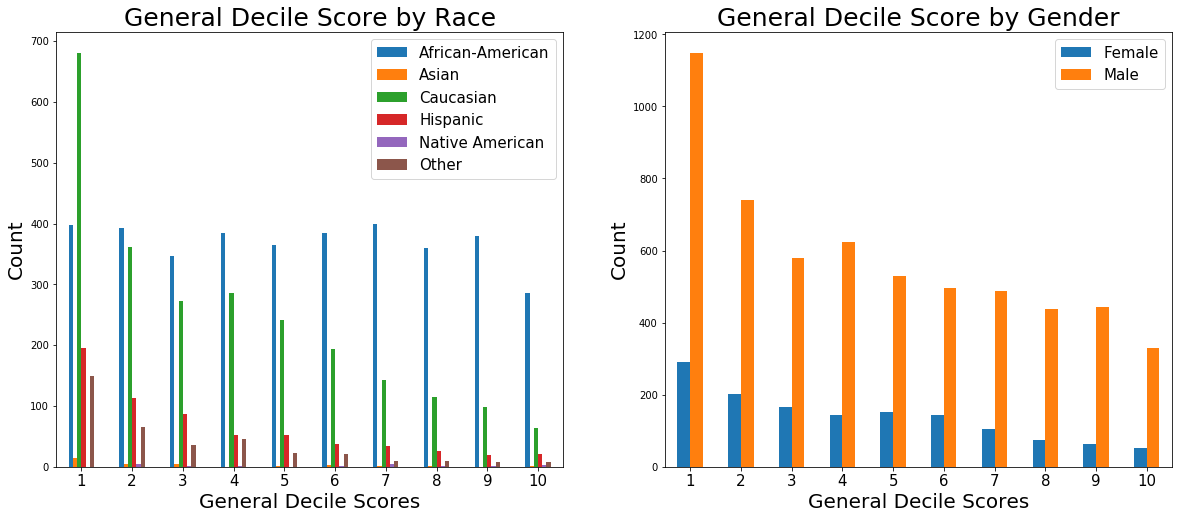

In [30]:
#general decile score by race and sex
genDR = data.groupby(['decile_score', 'race']).agg({
    'id': len
}).unstack()

genDS = data.groupby(['decile_score', 'sex']).agg({
    'id': len
}).unstack()

#visualize demographics
dfs = [genDR, genDS]
labels = ['Race', 'Gender']
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
for i, ax in enumerate(axes.flat):
    dfs[i].plot(ax = ax, kind = 'bar')
    ax.set_xticklabels(labels = dfs[i].index, rotation = 360, fontsize = 15)
    ax.set_xlabel('General Decile Scores', fontsize = 20)
    ax.set_ylabel('Count', fontsize = 20)
    ax.legend(list(dfs[i].columns.levels[1]), fontsize = 15)
    ax.set_title('General Decile Score by '+labels[i], fontsize = 25)
plt.show()

## III. Methodology

Given a black-box algorithm, $A$, we first define a quantity of interest, $Q$, which represents a property of the behavior of the algorithm for a given input distribution. $A$ operates on inputs or features, $i$, and every $i$ has a set of possible states it can take on, and $\mathbf{x}\in X$ is any vector representing a row the dataset that is drawn from the true *underlying* distribution represented by the random variable $X$. In the particular problem explored here, an example of an algorithm is Logistic Regression and an example of a feature is `race`, which can take on the following states: African-American, Caucasian, Hispanic, Asian, Native American and Other.

Formally, for a quantity of interest $Q_A(\cdot)$ and an input $i$, the Quantitative Input Influence of $i$ on $Q_A(\cdot)$ is defined as:
$$ \iota^{Q_A} = Q_A (X) - Q_A(X_{-i} U_i),$$
where the random variable $X_{-i}U_i$ represents the random variable with input $i$ replaced with a random sample, and represents the *intervened* distribution.

#### Unary QII
1. QII for individual outcomes:
    
    **One use of QII is to provide individuals with information on a particular classification outcome**. In order to quantify the use of an input for individual outcomes, we define the quantity of interest to be the classification outcome, $c$, for a particular individual, $\mathbf{x}$, given by $Q_{ind}^{\mathbf{x}} (\cdot) = \mathbb{E}(c(\cdot) = 1 | X = \mathbf{x})$. We can define the QII as: 
    $$ \iota^{\mathbf{x}}_{ind} =\mathbb{E}(c(X) = 1 | X = \mathbf{x}) - \mathbb{E}(c(X_{-i}U_i) = 1 | X = \mathbf{x})$$
    
   In our specific application, we are interested in the probability that a given feature is pivotal to the classification of an individual. We define this mathematically as:
   $$ \sum_{\mathbf{x}\in X}Pr(X=\mathbf{x}) \cdot \mathbb{E}(i\text{ is pivotal for }c(X)|X=\mathbf{x}) = \mathbb{E}(i\text{ is pivotal for }c(X))$$
    
2. QII for group disparity:

    **QII on group disparity denotes the association between classification outcomes and membership in a group.** In this case, the quantity of interest is the difference of postive classification outcomes between a given group and all others.
    $$Q_{disp}^\mathcal{Y} (\cdot)  = | \mathbb{E}(c(\cdot) = 1 | X \in \mathcal{Y}) -  \mathbb{E}(c(\cdot) = 1 | X \notin \mathcal{Y})|$$
    
    We can thus define the QII as: 
    $$\iota_{disp}^{\mathcal{Y}}(i) = Q_{disp}^{\mathcal{Y}} (X) - Q_{disp}^{\mathcal{Y}} (X_{-i}U_i)$$
    
 
#### Set and Marginal QII

In the overwhelming majority of real datasets, it is impossible to look at the *individual* influence of one feature on an outcome, as it is likely correlated with other features that were included in the decision making process. Thus, if we intervene on only one feature, changes to the outcome will be less likely, as the features correlated with it will still capture some of the feature in question's impact. So if we intervene on sets of features including a given feature, we may get a better understanding of the influence of the input by looking at its marginal influence.

For a quantity of interest, $Q$, and an input $i$, the QII of input $i$ over a set $S\subseteq N$ on $Q$ is defined to be
$$\iota^Q(i,S) = Q(X_{-S}U_{S}) - Q(X_{-S\cup\{i\}}U_{S\cup\{i\}}).$$ It is clear from the equation that the marginal QII of $i$ is the additional value in transparency achieved by including $i$ in a subset of features.

The marginal contribution of $i$ can vary depending on which set $S$ is considered, so we report the aggregate marginal contribution of $i$ to $S$, where S is sampled from some distribution over subsets of features. We use the Shapley value as a measure of this aggregate marginal contribution.

## IV. Evaluation and Results

### Write about 